In [1]:
# Standard libraries
import re
import warnings
from collections import Counter

# Data handling and processing
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Natural Language Processing
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Topic Modeling with Gensim
import gensim
from gensim import corpora, models
from gensim.models import LdaModel, CoherenceModel
from gensim.utils import simple_preprocess

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aishwarya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
amz = pd.read_excel('Amazon.xlsx')

In [3]:
amz.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'}).dtypes

Date              datetime64[ns]
Tweet content     string[python]
Tweet language    string[python]
Is a RT                     bool
Company Name      string[python]
dtype: object

In [4]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [5]:
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+|https\S+', '', tweet)

    # Remove user mentions
    tweet = re.sub(r'@[^\s]+', '', tweet)

    # Remove special characters, punctuation, numbers, and hyphens
    tweet = re.sub(r'[^a-zA-Z\s\-]', '', tweet)

    # Remove retweet indicators
    tweet = re.sub(r'\brt\b', '', tweet)

    # Remove emojis
    tweet = remove_emojis(tweet)

    # Convert data to lowercase
    tweet = tweet.lower()

    # Removing stopwords
    clean_words = [word for word in tweet.split() if word.lower() not in stopwords.words('english')]

    return ' '.join(clean_words)

In [6]:
# Word tokenization
def word_tokenization(tweet):
    # Tokenization
    words = nltk.word_tokenize(tweet)
    return words

In [7]:
# Initialize spaCy 'en_core_web_sm' model, keeping only tagger component for efficiency
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatization function adapted to process text directly
def lemmatization(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if token.pos_ in allowed_postags])

In [8]:
# Create a new DataFrame for the cleaned tweet content
amz_1 = pd.DataFrame()

# Create a new DataFrame by copying the columns you want from the original DataFrame
amz_1 = amz[['Date', 'Tweet language', 'Is a RT', 'Company Name']].copy()

In [9]:
# Apply preprocessing and tokenization
amz_1['Tweet content'] = amz['Tweet content']
amz_1['Tweet content'] = amz_1['Tweet content'].apply(preprocess_tweet)
amz_1['Tweet content'] = amz_1['Tweet content'].apply(word_tokenization)

In [10]:
amz_1['Tweet content'] = amz_1['Tweet content'].astype(str)

In [11]:
amz_1['Tweet content'] = amz_1['Tweet content'].apply(lemmatization)

In [12]:
# Conversion of the other datas
amz_1 = amz_1.astype({'Tweet language': 'string', 'Company Name': 'string'})

In [13]:
amz_1['Tweet content']

0        try discovery engine amp social network invest...
1        halvorsen buy facebook amazon mastercard googl...
2        stock surprise investor earning season adbe tt...
3          oneplus launch price rs ' available amazon read
4             ocado share plummet amazon fresh launch read
                               ...                        
38187    ' amazon tick reboot aim stand crowd superhero...
38188    swear watch trade everytime sell stock take tw...
38189                                       amzn want roll
38190    minute trade spy dia qqq pcln tsla googl ' bid...
38191    wall cupboard browser ' app echo appliance eve...
Name: Tweet content, Length: 38192, dtype: object

In [14]:
# Extracting the text from the 'Tweet content' column
tweet_texts = amz_1['Tweet content'].dropna().tolist()  # Drops any NaN values and convert to list

# Tokenizing the text and converting to lowercase
words = [word.lower() for text in tweet_texts for word in re.findall(r'\b\w+\b', text)]

# Counting the frequency of each word
word_counts = Counter(words)

# Getting the most common 50 words
top_50_words = word_counts.most_common(50)

# Displaying the results
for word, count in top_50_words:
    print(f'{word}: {count}')

amazon: 9404
amzn: 6660
stock: 4304
read: 3888
goog: 3782
spy: 3590
googl: 3113
tsla: 3025
msft: 2702
qqq: 2627
buy: 2205
new: 2023
trade: 1994
sell: 1897
amp: 1487
earning: 1474
market: 1459
high: 1336
day: 1318
get: 1266
today: 1213
go: 1188
video: 1171
see: 1160
good: 1132
make: 1056
prime: 1043
apple: 1027
call: 1000
service: 969
baba: 960
big: 951
short: 942
take: 926
week: 901
say: 895
wmt: 894
cloud: 879
retail: 871
tech: 867
time: 863
top: 854
long: 852
share: 847
bezo: 836
look: 835
price: 824
dia: 786
next: 735
quant: 720


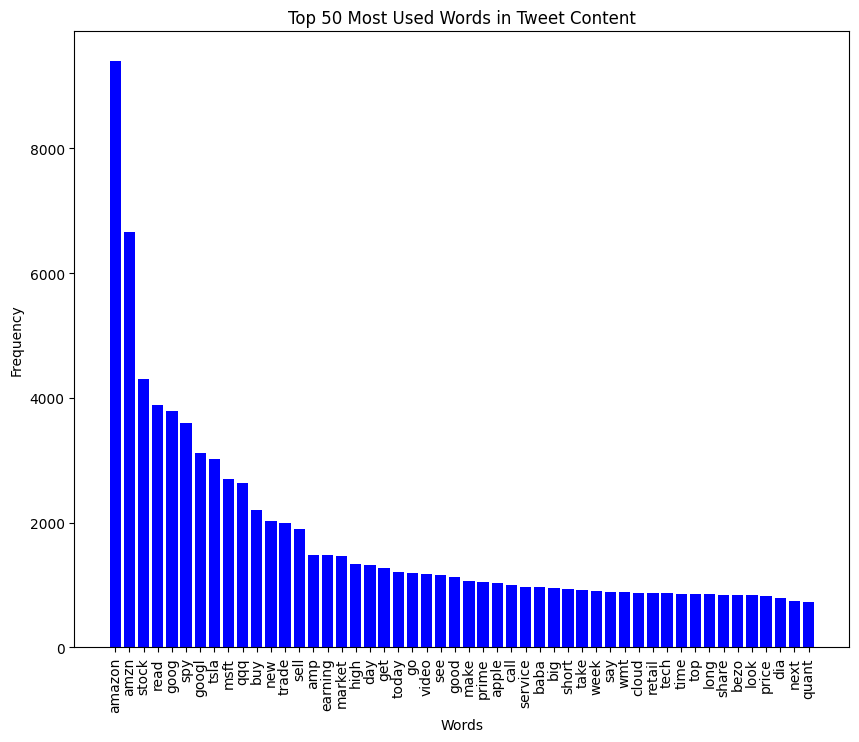

In [15]:
# Preparing data for plotting
words, frequencies = zip(*top_50_words)  # Unzipping the words and their counts

# Plotting
plt.figure(figsize=(10, 8))
plt.bar(words, frequencies, color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 50 Most Used Words in Tweet Content')
plt.show()

 For semantic analysis:
 -  'stocks', 'stock', 'earnings', 'market', 'trading', 'trade', 'short', maybe relevant for financial analysis,
 - Words that are too common or generic may not add much value to understanding specific topics. For instance, 'new', 'buy', 'sell', 'day', 'today', 'see', 'like', 'top', 'may', and 'week'.
 - Words like 'via' and 'amp' (which is often used in place of '&') are generally not useful in topic modeling.
 - Words like 'rt' (retweet), 'read', and 'video' might be more about the format or action related to the content rather than the content itself.
 - While 'amzn', 'fb', 'aapl', 'nflx', 'goog', 'googl', 'tsla', 'msft', 'qqq', 'twtr', 'spx', 'iwm', 'baba', 'wmt', 'apple', 'bezos', 'dia', 'lnkd', 'ibm' are relevant for financial or stock market-related discussions.
 - Words such as 'inc' (incorporated), which could be part of many company names, don't add much to the semantic content. 'Prime' might refer to Amazon Prime specifically but could be considered too specific for the topic model focuses on Amazon services.

In [16]:
def replace_specific_words(text):
    # Mapping for words
    replacements = {
        'amzn': 'amazon',
        'goog': 'google',
        'baba': 'ali baba',
        'tsla': 'tesla',
        'msft': 'microsoft',
        'fb': 'facebook',
        'aapl': 'apple',
        'googl': 'google',
        'twtr': 'twitter',
        'amazons': 'amazon',
        'googlee': 'google',
        'googleel': 'google',
        'nflx': 'netflix',
        'ali': 'ali baba',
        'lnkd': 'linkedin',
        'yhoo': 'yahoo',
        'googlele': 'google',
        'vrx': 'Valeant Pharmaceuticals International, Inc.'
    }
    # Replace each key with the value in the text
    for key, value in replacements.items():
        text = text.replace(key, value)
    return text

# Update the 'Tweet content' column by applying the replacement function
amz_1['Tweet content'] = amz_1['Tweet content'].apply(replace_specific_words)

In [17]:
# Improved list of words to remove, ensuring lowercase for comparison
words_to_remove = ['new', 'buy', 'sell', 'day', 'today', 'see', 'like', 'top', 'may', 'week', 'inc', 'could', 'long', 'inc',
                   'via', 'amp', 'rt', 'read', 'video', 'pt', 'next', 'time', 'c', 'year', 'see', 'look', 'need', 'u', '-']

# Enhanced function to remove specified words from a text
def remove_neutral_words(text, remove_list):
    # Creating a pattern that matches any of the words to remove
    pattern = r'\b(' + '|'.join(remove_list) + r')\b'
    # Replacing matched words with nothing (i.e., removing them), case-insensitive
    cleaned_text = re.sub(pattern, '', text, flags=re.IGNORECASE)
    # Removing extra spaces that may be left after word removal
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

In [18]:
# Applying the remove_neutral_words to the 'Tweet content' column
amz_1['Tweet content'] = amz_1['Tweet content'].apply(lambda x: remove_neutral_words(x, words_to_remove))

In [19]:
# Flatten the list of words from all tweets into a single list
all_words = [word for content in amz_1['Tweet content'] for word in content.split()]

# Count each word's frequency
word_counts = Counter(all_words)

# Get the most common words and their frequencies
most_common_words = word_counts.most_common(50)
words, frequencies = zip(*most_common_words)

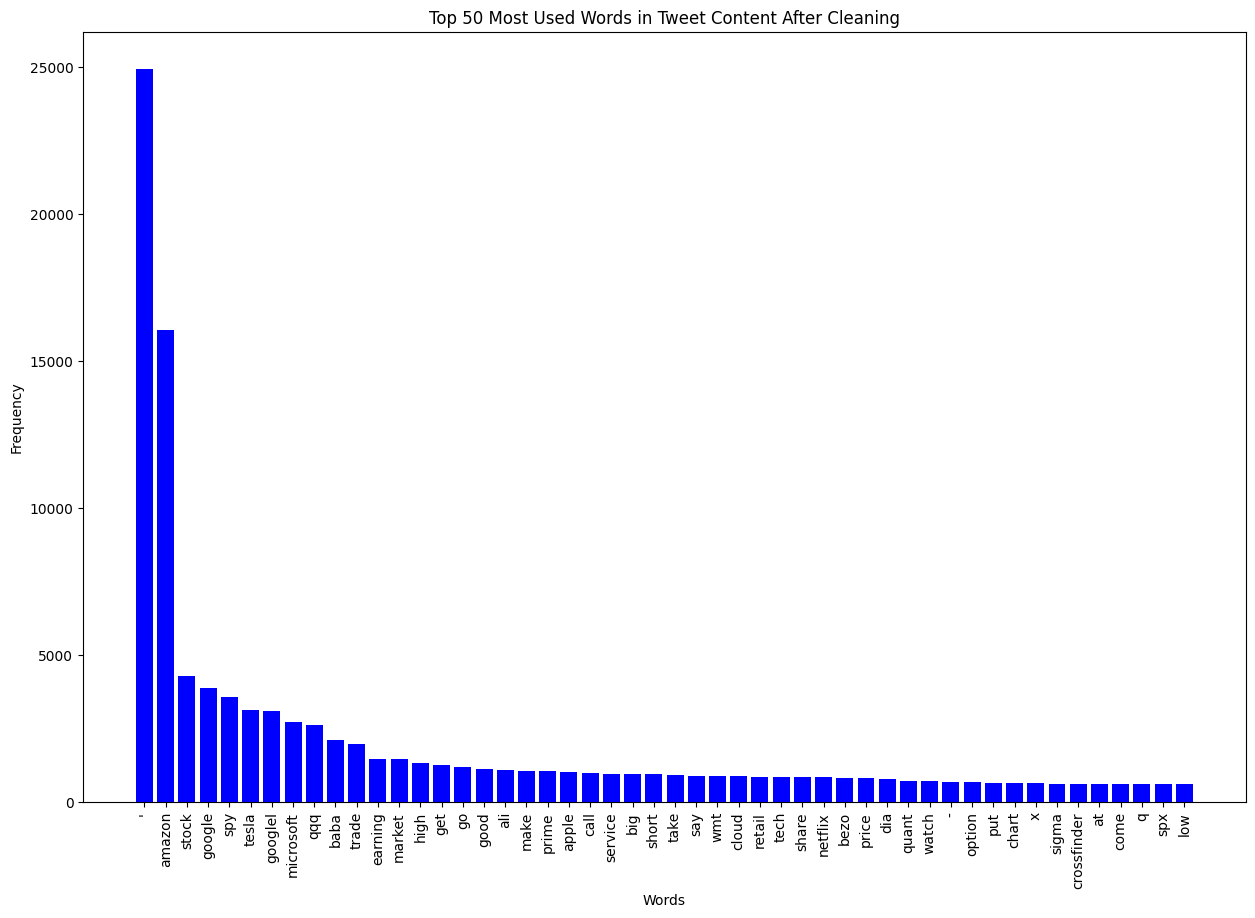

In [20]:
# Plotting
plt.figure(figsize=(15, 10))
plt.bar(words, frequencies, color='blue')  # Plot with the most common words
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.title('Top 50 Most Used Words in Tweet Content After Cleaning')
plt.show()

- Q is a former Nasdaq designation that noted a company had filed for bankruptcy.

In [21]:
# Convert the data type
amz_1.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'}).dtypes

# Conversion
amz_1 = amz_1.astype({'Tweet content': 'string', 'Tweet language': 'string', 'Company Name': 'string'})

In [22]:
# Tokenize the cleaned tweets
amz_1['clean_tweet'] = amz_1['Tweet content'].apply(preprocess_tweet)
tokenized_tweets = amz_1['clean_tweet'].apply(lambda x: simple_preprocess(x, deacc=True))

# Create dictionary
dictionary = corpora.Dictionary(tokenized_tweets)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Create corpus
corpus = [dictionary.doc2bow(tweet) for tweet in tokenized_tweets]

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=100, alpha='auto', per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Set parameters
start=2; limit=15; step=2
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_tweets, start=start, limit=limit, step=step)

c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  upcast = np.find_common_type(args, [])
c:\Users\Aishwarya\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\sparse\_sputils.py:44: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes

In [27]:
# Selecting the model and print the topics with the highest coherence score
best_model = model_list[coherence_values.index(max(coherence_values))]
topics = best_model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.062*"come" + 0.046*"customer" + 0.031*"play" + 0.031*"give" + 0.027*"stop" + 0.027*"rate"')
(1, '0.058*"short" + 0.031*"news" + 0.027*"business" + 0.026*"update" + 0.025*"talk" + 0.020*"pfe"')
(2, '0.049*"say" + 0.047*"bezo" + 0.040*"want" + 0.034*"add" + 0.029*"monthly" + 0.028*"facebook"')
(3, '0.185*"spy" + 0.105*"baba" + 0.086*"qqq" + 0.055*"ali" + 0.043*"yahoo" + 0.037*"dia"')
(4, '0.035*"international" + 0.035*"great" + 0.034*"deal" + 0.033*"help" + 0.033*"valeant" + 0.032*"pharmaceuticals"')
(5, '0.161*"google" + 0.134*"microsoft" + 0.119*"tesla" + 0.109*"googlel" + 0.047*"qqq" + 0.039*"quant"')
(6, '0.077*"button" + 0.062*"dash" + 0.035*"twitter" + 0.032*"invest" + 0.032*"option" + 0.028*"bidu"')
(7, '0.157*"stock" + 0.043*"go" + 0.037*"big" + 0.035*"apple" + 0.034*"make" + 0.032*"watch"')
(8, '0.334*"amazon" + 0.030*"prime" + 0.025*"get" + 0.020*"service" + 0.020*"good" + 0.018*"cloud"')
(9, '0.190*"trade" + 0.091*"netflix" + 0.040*"gpro" + 0.038*"free" + 0.035*"order" 

In [28]:
# Print coherence scores for each model
print("Coherence Scores for Each Topic:")
for i, score in enumerate(coherence_values):
    print(f"Num Topics: {1 + i*1}, Score: {score}")

Coherence Scores for Each Topic:
Num Topics: 1, Score: 0.25031817984698024
Num Topics: 2, Score: 0.33415920889854767
Num Topics: 3, Score: 0.38378525632765387
Num Topics: 4, Score: 0.3969799101688648
Num Topics: 5, Score: 0.38262682366851747
Num Topics: 6, Score: 0.4136300955136869
Num Topics: 7, Score: 0.41130823263219335


- The coherence scores increase as the number of topics goes up, peaking at six topics, which indicates the most meaningful semantic relationship between words within the topics. Adding more topics beyond six doesn't significantly improve coherence, suggesting six is the optimal number of topics for this model.

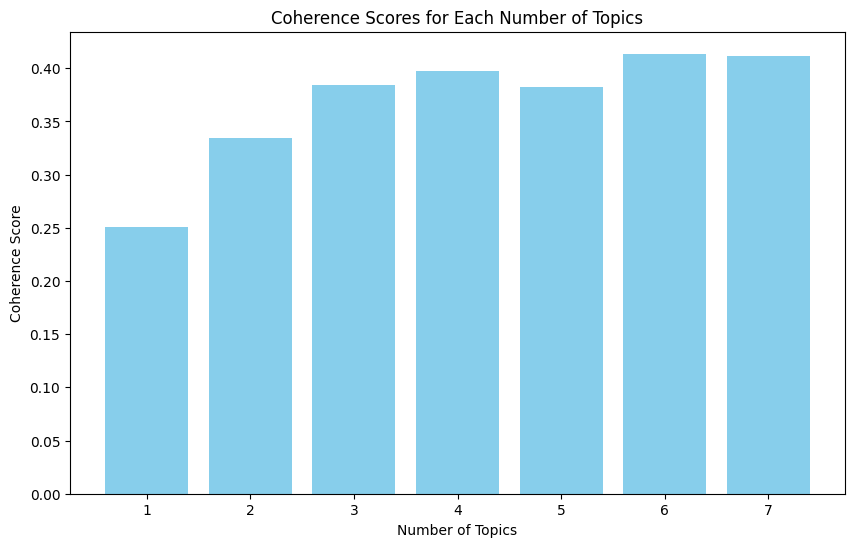

In [30]:
# Number of topics corresponding to the coherence values
num_topics = [1 + i for i in range(len(coherence_values))]

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(num_topics, coherence_values, color='skyblue')

# Title and labels
plt.title('Coherence Scores for Each Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.xticks(num_topics)

# Display the plot
plt.show()

# LDA Visualisation
- The size of the bubbles can represent various metrics like the marginal topic distribution, indicating how much text is associated with each topic.
- When λ equals 1, terms are ranked based only on how likely they are within the topic, which might favor common terms. When λ equals 0, terms are ranked solely by their uniqueness, highlighting more unusual terms. Adjusting λ lets you explore different aspects of how terms contribute to a topic, refining its description.
- The map visualizes the topics on a two-dimensional plane using multidimensional scaling (MDS). The closer two topics are on this map, the more similar they are in terms of their content and term composition
- These metrics provide insight into how often terms appear in general versus within specific topics.

**Formulas:**
- Saliency is a measure of how much a term both appears frequently and distinctively in a topic. 
- Relevance combines the frequency of a term within a topic (its exclusivity) and across all documents, adjusted by λ.


In [29]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(best_model, corpus, dictionary)
pyLDAvis.display(vis)

# General Topic Overview

- ***Tech Innovations and Earnings Reports:*** Product launches and earnings reports from companies like Google and Amazon were regularly discussed. For example, Amazon's innovations in cloud services and e-commerce platform expansion were featured in news and tweets, aligning with the semantic topics of Amazon, cloud services, and retail innovations.​ 

- ***Stock Trading and Market Performance:*** During an active trading period, the semantic analysis also revealed repeated references to trading activities like calls and options. This is consistent with observed market trends, where the NASDAQ-100 displayed volatility and high trading volumes, especially in the index's high-performing tech stocks.​

- ***Corporate Strategy and Financial Performance:*** During this time, discussions of earnings, business expansions, and financial strategies were common. During this period, big tech companies were actively pursuing expansion strategies in addition to reporting quarterly results. This was reflected in the semantic topics surrounding financial strategies and company growth.​

- ***Investor Sentiment and Market Reactions:*** The analysis topics pertaining to investor sentiment and market reactions were probably impacted by the general state of the market as well as company-specific news, which frequently sparks interesting conversations on social media sites like Twitter. For instance, conversations about "stock" and "earnings" reflect the mood of the market as a whole and the excitement surrounding major corporations' quarterly earnings reports.​ 

- ***Particular Announcements and Events:*** During this time period, certain companies such as Alibaba and Yahoo were mentioned specifically, probably in relation to particular financial disclosures or news events. This would have sparked conversations in the tweets that were gathered for the semantic analysis.​ 

# Results:
- ***Topic 1*** seems to be highly associated with Amazon's range of services and products. Key terms such as "amazon," "prime," "service," "cloud," "kindle," "expand," "delivery," and "aws" suggest that this topic covers various aspects of Amazon's business. It includes their Prime subscription service, cloud computing services (potentially AWS - Amazon Web Services), their Kindle product line, and their delivery services. Other terms like "price," "share," "target," "sale," "company," "product," and "retail" indicate discussions related to the business and market aspects of Amazon, such as stock prices, market targets, sales performance, and their role in the retail sector. The presence of terms like "growth," "plan," "start," "launch," and "expand" suggest a focus on Amazon's growth strategies, new initiatives, product launches, and expansion plans. The terms "sprint," "month," "first," "last," and "beat" might relate to financial reporting, business quarters, or competitive strategies.

- In ***Topic 2*** theme centers around the financial and technological aspects of several companies, with a particular emphasis on the stock market and technology products.  "stock," "big," "make," "gain," "increase," "large," "money," "bank," "follow," "etf": These suggest discussions related to the stock market, investment strategies, financial gains, banking, and possibly exchange-traded funds (ETFs).
"apple," "watch," "tech," "fitbit," "app," "echo": These terms point towards technology products, likely referencing Apple's product line (including the Apple Watch), fitness tracking devices like Fitbit, and perhaps Amazon's Echo.
"go," "chart," "pick," "run," "keep," "find": These could be related to stock market analysis and decision-making processes in financial contexts, such as choosing stocks, analyzing performance charts, and monitoring investments.
"ebay": This is a specific reference to the e-commerce platform, which might be discussed in the context of its stock performance, technology, or business model.

- ***Topic 3*** is centered on the intersection of technology and finance, discussing major tech companies like Google, Microsoft, and Tesla, and investment-related topics highlighted by references to stock tickers and quantitative analysis. It suggests a focus on stock market activity, company performance, and technological innovations within the finance sector.

- ***Topic 4*** delves into market strategies and sentiment, referencing terms like "market," "high," "call," "put," and "bullish," which are associated with trading actions and investor outlook. "Artificial intelligence" suggests a tech element, possibly relating to AI's impact on the market or as an investment sector. "Seekingalpha" indicates a focus on financial analysis, as it's a platform for stock market insights. This topic combines market movements, trading strategies, and financial analysis.

- ***Topic 5*** appears focused on the stock market and financial instruments. With references to "spy," "baba," "qqq," and "yahoo," it includes stock tickers and indexes, indicating discussions on individual stocks and the market overall. "Volatility" and "vix" point to market volatility discussions, while "finance" and "stockmarket" suggest a broad coverage of financial topics. This topic likely captures conversations around market analysis, trends, and trading.